In [1]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [2]:
measurements = pd.read_csv('measurements_with_postcode.csv')
#measurements = pd.read_csv('phosphor.measurements.csv')
ameasurements = pd.read_csv('phosphor.csv')
postcodes = pd.read_csv('data/German-Zip-Codes.csv', sep=';')
subsidies = pd.read_csv('niedersachsen-subsidies.csv')

/home/aivuk/.virtualenvs/nabu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
subsidies['postcode'] = subsidies.recipient_postcode.str.slice(3)

In [106]:
ameasurements['postcode'] = np.zeros(ameasurements.shape[0])
not_found = []
for i,r in ameasurements.iterrows():
    #print(measurements[measurements['Messtelle'] == r['Messtelle Nr.']]['postcode'])
    try:
        ameasurements.loc[i,'postcode'] = measurements[measurements['Messtelle'] == r['Messtelle Nr.']]['postcode'].iloc[0]
    except:
        not_found.append( r['Messtelle Nr.'])


In [108]:
ameasurements.to_csv('phosphor-post.csv')
measurements = pd.read_csv('phosphor-post.csv')

/home/aivuk/.virtualenvs/nabu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
lr = linear_model.LinearRegression()


In [137]:
measurements

,Unnamed: 0,Messtelle Nr.,Messstelle,Datum,Parameter,Kennung,Messwert,Einheit,Nitrat-Schwellenwert (Umweltqualitätsnorm),Trend Nitrat,UTM-Rechtswert,UTM-Hochwert,postcode
0,0,100001262,522 LBH 22 Hesel,2015-09-25,Nitrat,NaN,83.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
1,1,100001262,522 LBH 22 Hesel,2015-07-01,Mittelwert Jahr,NaN,81.30,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
2,2,100001262,522 LBH 22 Hesel,2015-06-16,Nitrat,NaN,79.70,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
3,3,100001262,522 LBH 22 Hesel,2014-10-23,Nitrat,NaN,110.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
4,4,100001262,522 LBH 22 Hesel,2014-07-01,Mittelwert Jahr,NaN,110.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
5,5,100001262,522 LBH 22 Hesel,2013-07-01,Mittelwert Jahr,NaN,87.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
6,6,100001262,522 LBH 22 Hesel,2013-06-25,Nitrat,NaN,87.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
7,7,100001262,522 LBH 22 Hesel,2012-07-01,Mittelwert Jahr,NaN,110.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
8,8,100001262,522 LBH 22 Hesel,2012-06-28,Nitrat,NaN,110.00,mg/l,50,kein signifikanter Trend,32408906,5903536,26835
9,9,100001262,522 LBH 22 Hesel,2011-07-01,Mittelwert Jahr,NaN,82.60,mg/l,50,kein signifikanter Trend,32408906,5903536,26835


In [4]:
measurements.Datum = pd.to_datetime(measurements.Datum, format='%Y-%m-%d')


In [139]:
meas_post = measurements.groupby('postcode')['Messwert'].agg('mean')
subs_post = subsidies.groupby('postcode')['amount'].agg('sum')
meas_without_sub = [p for p in subs_post.index if int(p) not in meas_post]
meas_with_sub = [p for p in subs_post.index if int(p) in meas_post]

In [140]:
len(meas_with_sub), len(meas_witdhout_sub)

(483, 324)

In [113]:
def correlate_subsidies(year=2016, scheme='EGFL: Befristete Sonderbeihilfe für Erzeuger der Tierhaltungssektoren'):
    subs_f = subsidies[(subsidies['year'] == year) & (subsidies['scheme'] == scheme)]    
    subs_post = subs_f.groupby('postcode')['amount'].agg('sum')
    measurement_year = year
    if year == 2016:
        measurement_year = 2015
    
    meas_post = measurements[measurements.Datum.dt.year == measurement_year].groupby('postcode')['Messwert'].agg('mean')
    meas_without_sub = [p for p in subs_post.index if int(p) not in meas_post]
    meas_with_sub = [p for p in subs_post.index if int(p) in meas_post]
    
    amount_arr = np.array([[v] for v in subs_post[meas_with_sub]])
    meas_arr = np.array(meas_post[[int(i) for i in meas_with_sub]])
    
    lr.fit(amount_arr, meas_arr)
    
    fig, ax = plt.subplots()
    ax.scatter(amount_arr, meas_arr)
    ax.plot([amount_arr.min(), amount_arr.max()], [meas_arr.min(), meas_arr.max()], 'k--')
    ax.plot(amount_arr, lr.predict(amount_arr), 'k', color='red')

    ax.set_xlabel('Subsidies Total')
    ax.set_ylabel('Nitrate average')
    plt.show()
    
    meas_predicted =  lr.predict(amount_arr)
    
    
    print("Correlation: {0:.2f}".format(np.corrcoef(amount_arr.flatten(),meas_arr)[0][1]))
    # The coefficients
    print('Coefficients: \n', lr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
      % mean_squared_error(meas_arr, meas_predicted))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(meas_arr, meas_predicted))



In [114]:
m = measurements.Datum.dt.year.unique()
m.sort()

years = measurements.Datum.dt.year.unique()
for y in years:
    print('{} => {}'.format(y, measurements[measurements.Datum.dt.year == y].shape[0]))

2015 => 4734
2014 => 4708
2013 => 4755
2012 => 4692
2011 => 4720
2010 => 4579
2009 => 4649
2008 => 4577
2007 => 4155
2006 => 4060
2005 => 4030
2004 => 4037
2003 => 3949
2002 => 3834
2001 => 3938
2000 => 3904


In [48]:
!soffice phosphor.measurements.csv

javaldx: Could not find a Java Runtime Environment!
Please ensure that a JVM and the package libreoffice-java-common
is installed.
If it is already installed then try removing ~/.libreoffice/3/user/config/javasettings_Linux_*.xml


# 2016 - EGFL: Befristete Sonderbeihilfe für Erzeuger der Tierhaltungssektoren

In [115]:
correlate_subsidies(year=2015, scheme='EGFL: Befristete Sonderbeihilfe für Erzeuger der Tierhaltungssektoren' )

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# 2014 - EGFL: Direktzahlungen

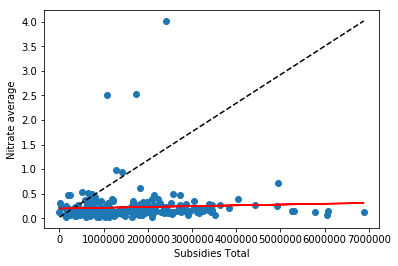

Correlation: 0.06
Coefficients: 
 [1.62187427e-08]
Mean squared error: 0.12
Variance score: 0.00


In [116]:
correlate_subsidies(year=2014, scheme='EGFL: Direktzahlungen' )

# 2016 - EGFL: Basisprämie

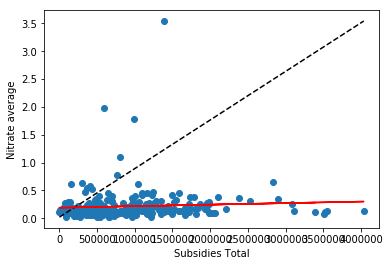

Correlation: 0.07
Coefficients: 
 [2.73825078e-08]
Mean squared error: 0.09
Variance score: 0.00


In [117]:
correlate_subsidies(year=2016, scheme='EGFL: Basisprämie' )

# 2016 - ELER: Agrarumwelt- und Klimaschutzmaßnahmen

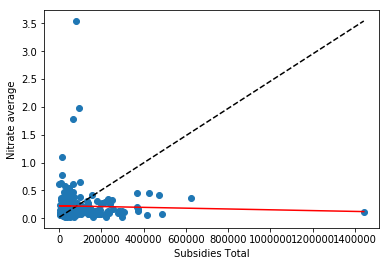

Correlation: -0.03
Coefficients: 
 [-7.28544675e-08]
Mean squared error: 0.09
Variance score: 0.00


In [118]:
correlate_subsidies(year=2016, scheme='ELER: Agrarumwelt- und Klimaschutzmaßnahmen' )

# Top 10 Postcode Subsidies

## By total

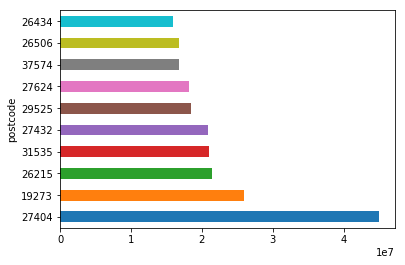

In [15]:
subsidies.groupby('postcode')['amount'].agg('sum').sort_values(ascending=False)[:10].plot.barh()

## By count

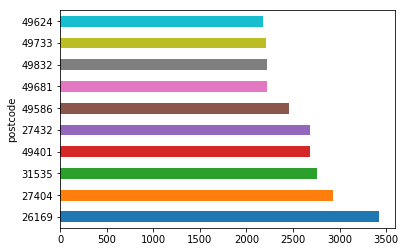

In [115]:
subsidies.groupby('postcode')['recipient_id'].agg('count').sort_values(ascending=False)[:10].plot.barh()

# Top 10 Postcodes Nitrate

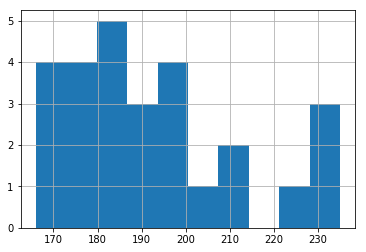

In [152]:
measurements[measurements.postcode == 49770]['Messwert'].hist()

In [9]:
def avg_trend(postcode):
    series = measurements[measurements.postcode == postcode].groupby(measurements.Datum.dt.year)['Messwert'].agg('mean')
    return {postcode: series.iloc[-1] - series.iloc[0]}

In [12]:
trend = measurements.postcode.apply(avg_trend)

In [18]:
trend_df = pd.DataFrame({'postcode': measurements.postcode, 'value': trend})

In [24]:
trend_df.iloc[trend_df['value'].idxmax()]

postcode    29320.00
value         130.06
Name: 19602, dtype: float64

In [29]:
trend_df.iloc[trend_df['value'].idxmin()]

postcode    27628.000000
value        -114.333333
Name: 7331, dtype: float64

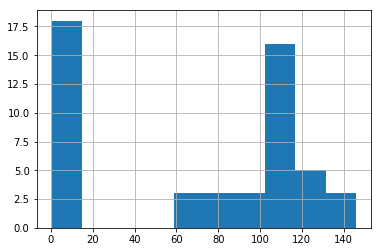

In [25]:
measurements[measurements.postcode == 29320]['Messwert'].hist()

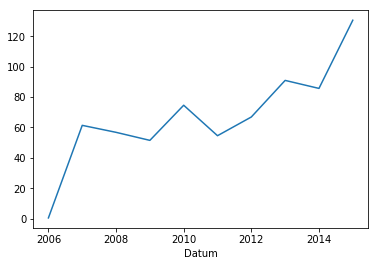

In [28]:
measurements[measurements.postcode == 29320].groupby(measurements.Datum.dt.year)['Messwert'].agg('mean').plot()

In [32]:
subsidies[subsidies.postcode == '29320']['amount'].sum()

4135893.4499999997

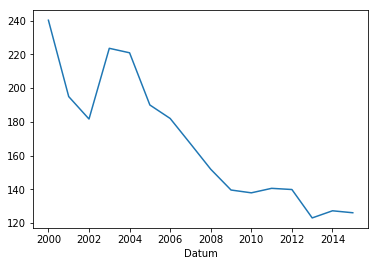

In [35]:
measurements[measurements.postcode == 27628].groupby(measurements.Datum.dt.year)['Messwert'].agg('mean').plot()

In [36]:
subsidies[subsidies.postcode == '27628']['amount'].sum()

10763552.139999999

In [150]:
subsidies[subsidies.postcode == '49770'].groupby('recipient_name')['amount'].sum().sort_values(ascending=False)

recipient_name
Pott, Alois                      268852.70
Beelmann, Josef                  212526.65
M. & M. Bergmann GbR             189400.48
Maue KG                          184132.75
Busch, Ferdinand                 179281.08
Duisen GbR                       145652.97
Tietze-Meyer KG                  132659.09
Decker, Jürgen                   112738.17
H.-J. & M. Langenhorst GbR        99663.91
Bockwinkel, Bernd                 93591.32
Alois Pott GbR                    92749.43
Heskamp KG                        91646.41
Burke, Clemens                    90727.01
Hegger, Clemens                   88386.26
Schnelker, Wilhelm                85845.04
Feldhaus, Michael                 85066.96
Wilbers, Norbert                  83080.75
Brokjans, Johannes                80972.18
Bohmann, Martin                   80199.52
Griep, Heinrich                   77534.53
Ahlers, Heiner                    74260.30
Scheer, Georg                     73106.52
Wietkamp-Woltering, Lothar        72824

In [141]:
measurements.groupby('postcode')['Messwert'].agg('mean').sort_values(ascending=False)

postcode
49770    191.444444
27628    157.874627
38459    157.219512
31603    129.661532
31228    122.475000
38124    117.602941
48499    112.048718
21755    107.083333
38176    103.390909
29565    103.233333
29485    102.268421
27248     97.810000
38474     97.421429
21629     97.045714
31638     95.968000
31234     94.460759
38542     93.776389
26835     89.771257
38442     89.479706
27333     88.710811
29488     86.361446
21702     84.512500
27245     84.052245
21258     84.050000
27721     83.617949
21640     83.109091
30982     80.877273
29386     79.560684
27386     79.104257
21717     76.984272
            ...    
21787      0.411304
21635      0.411163
21720      0.410000
21745      0.410000
21706      0.408571
21684      0.408571
21709      0.407000
27751      0.406071
21683      0.405263
26506      0.401818
21770      0.401739
26683      0.401176
38364      0.401034
29439      0.400000
26133      0.385161
27442      0.383692
26446      0.381865
26553      0.371875
21765      

# 2014 - Top 10 Postcode Subsidies (Direktzahlungen)

## by total

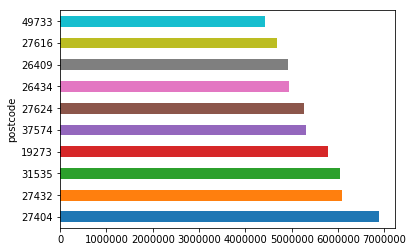

In [209]:
subsidies[(subsidies.scheme == 'EGFL: Direktzahlungen')  & (subsidies.year == 2014)].groupby('postcode')['amount'].agg('sum').sort_values(ascending=False)[:10].plot.barh()

## by count

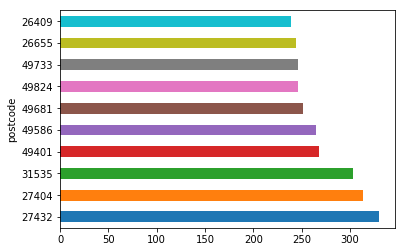

In [208]:
subsidies[(subsidies.scheme == 'EGFL: Direktzahlungen') & (subsidies.year == 2014)].groupby('postcode')['recipient_id'].agg('count').sort_values(ascending=False)[:10].plot.barh()

# 2015 - Top 10 Postcode Subsidies (Direktzahlungen + umverteilung + krisenreserve)

## by total

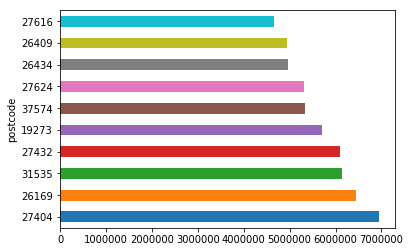

In [213]:
subsidies[(subsidies.scheme.isin(['EGFL: Direktzahlungen', 'EGFL: Umverteilungsprämie', 'EGFL: Erstattung nicht genutzter Mittel der Krisenreserve']))  & (subsidies.year == 2015)].groupby('postcode')['amount'].agg('sum').sort_values(ascending=False)[:10].plot.barh()

## by count

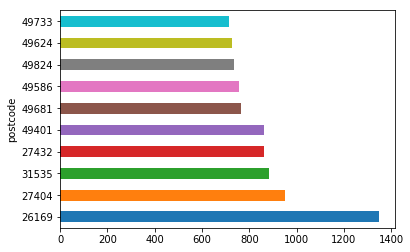

In [214]:
subsidies[(subsidies.scheme.isin(['EGFL: Direktzahlungen', 'EGFL: Umverteilungsprämie', 'EGFL: Erstattung nicht genutzter Mittel der Krisenreserve']))  & (subsidies.year == 2015)].groupby('postcode')['recipient_id'].agg('count').sort_values(ascending=False)[:10].plot.barh()

# 2016 - Top 10 Postcode Subsidies ('EGFL: Basisprämie' + 'EGFL: Greening-Prämie' + umverteilung + krisenreserve)

## by total

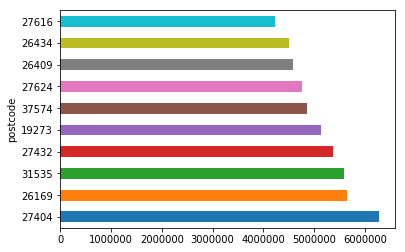

In [216]:
subsidies[(subsidies.scheme.isin(['EGFL: Basisprämie', 'EGFL: Greening-Prämie', 'EGFL: Umverteilungsprämie', 'EGFL: Erstattung nicht genutzter Mittel der Krisenreserve']))  & (subsidies.year == 2016)].groupby('postcode')['amount'].agg('sum').sort_values(ascending=False)[:10].plot.barh()

## by count

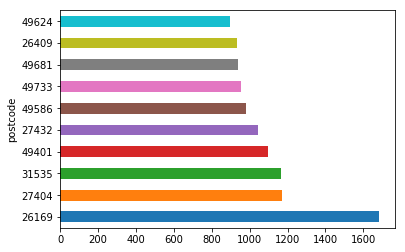

In [217]:
subsidies[(subsidies.scheme.isin(['EGFL: Basisprämie', 'EGFL: Greening-Prämie', 'EGFL: Umverteilungsprämie', 'EGFL: Erstattung nicht genutzter Mittel der Krisenreserve']))  & (subsidies.year == 2016)].groupby('postcode')['recipient_id'].agg('count').sort_values(ascending=False)[:10].plot.barh()

In [9]:
    subs_post = subsidies.groupby('postcode')['amount'].agg('sum')
    meas_post = measurements[measurements.Datum.dt.year == 2015].groupby('postcode')['Messwert'].agg('mean')
    meas_without_sub = [p for p in subs_post.index if int(p) not in meas_post]
    meas_with_sub = [p for p in subs_post.index if int(p) in meas_post]

In [11]:
len(meas_with_sub)

477

In [12]:
len(meas_without_sub)

330

In [25]:
len(subsidies['postcode'].unique())

807

In [23]:
len(measurements['postcode'].unique())

485

In [19]:
subsidies[(subsidies.postcode == '21737') & (subsidies.year == 2015)]

,Unnamed: 0,recipient_name,recipient_id,recipient_postcode,recipient_location,scheme,amount,currency,year,country,postcode
62927,8773,"Heinsohn, Rolf",DE-7f8463df-c88d-4d25-beb7-ffb28adfd990,DE-21737,Wischhafen,EGFL: Direktzahlungen,2376.14,EUR,2015,DE,21737
62928,8774,"Heinsohn, Rolf",DE-7f8463df-c88d-4d25-beb7-ffb28adfd990,DE-21737,Wischhafen,EGFL: Erstattung nicht genutzter Mittel der Kr...,21.89,EUR,2015,DE,21737
62929,8775,"Heinsohn, Rolf",DE-7f8463df-c88d-4d25-beb7-ffb28adfd990,DE-21737,Wischhafen,EGFL: Umverteilungsprämie,397.68,EUR,2015,DE,21737
64486,20103,"Elsen, Niels",DE-8ed7d6c7-fd66-4e61-9da3-6d0dde2aa57d,DE-21737,Wischhafen,EGFL: Direktzahlungen,10002.69,EUR,2015,DE,21737
64487,20104,"Elsen, Niels",DE-8ed7d6c7-fd66-4e61-9da3-6d0dde2aa57d,DE-21737,Wischhafen,EGFL: Erstattung nicht genutzter Mittel der Kr...,272.28,EUR,2015,DE,21737
64488,20105,"Elsen, Niels",DE-8ed7d6c7-fd66-4e61-9da3-6d0dde2aa57d,DE-21737,Wischhafen,EGFL: Umverteilungsprämie,1622.42,EUR,2015,DE,21737
64748,22058,"Sölter, Regina",DE-c0c15f25-c284-4656-a9d0-68a99a4c6497,DE-21737,Wischhafen,EGFL: Direktzahlungen,4059.92,EUR,2015,DE,21737
64749,22059,"Sölter, Regina",DE-c0c15f25-c284-4656-a9d0-68a99a4c6497,DE-21737,Wischhafen,EGFL: Erstattung nicht genutzter Mittel der Kr...,77.58,EUR,2015,DE,21737
64750,22060,"Sölter, Regina",DE-c0c15f25-c284-4656-a9d0-68a99a4c6497,DE-21737,Wischhafen,EGFL: Umverteilungsprämie,682.62,EUR,2015,DE,21737
64751,22061,"Sölter, Regina",DE-c0c15f25-c284-4656-a9d0-68a99a4c6497,DE-21737,Wischhafen,ELER: Agrarumweltmaßnahmen,1148.40,EUR,2015,DE,21737


In [13]:
meas_without_sub

['19273',
 '21224',
 '21227',
 '21228',
 '21244',
 '21259',
 '21261',
 '21266',
 '21271',
 '21335',
 '21337',
 '21339',
 '21354',
 '21357',
 '21358',
 '21360',
 '21365',
 '21371',
 '21380',
 '21382',
 '21388',
 '21394',
 '21395',
 '21397',
 '21398',
 '21401',
 '21403',
 '21406',
 '21407',
 '21409',
 '21438',
 '21439',
 '21442',
 '21444',
 '21445',
 '21447',
 '21522',
 '21614',
 '21641',
 '21643',
 '21647',
 '21680',
 '21682',
 '21698',
 '21712',
 '21714',
 '21727',
 '21729',
 '21730',
 '21732',
 '21734',
 '21737',
 '21739',
 '21756',
 '21762',
 '21763',
 '21770',
 '21772',
 '21776',
 '21781',
 '21782',
 '21784',
 '26121',
 '26122',
 '26123',
 '26129',
 '26131',
 '26135',
 '26382',
 '26386',
 '26389',
 '26419',
 '26427',
 '26434',
 '26452',
 '26474',
 '26486',
 '26489',
 '26524',
 '26556',
 '26603',
 '26639',
 '26689',
 '26721',
 '26723',
 '26757',
 '26802',
 '26842',
 '26844',
 '26847',
 '26849',
 '26897',
 '26904',
 '26906',
 '26936',
 '27246',
 '27249',
 '27251',
 '27254',
 '27257',
